In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
import matplotlib.pyplot as plt
import requests
import zipfile
from pathlib import Path

Download the dataset

In [2]:
# Download the dataset
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print("Dataset already downloaded")
else:
    print("Downloading dataset...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        r = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", stream=True)
        print("Downloading dataset...")
        f.write(r.content)

    # Unzip the dataset
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
        print("Extracting dataset...")
        zip_ref.extractall(image_path)
        print("Done!")

Dataset already downloaded


Visualize the dataset

In [3]:
import os

def walk_through_dir(dir_path):
    for root, dirs, files in os.walk(dir_path):
        print(f"There are {len(dirs)} directories and {len(files)} files in '{root}'.")

In [4]:
# Walk through the data directory
walk_through_dir(image_path)

There are 2 directories and 0 files in 'data/pizza_steak_sushi'.
There are 3 directories and 0 files in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 files in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 files in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 files in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 files in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 files in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 files in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 files in 'data/pizza_steak_sushi/train/sushi'.


In [5]:
# Setup train and test paths
train_path = image_path/"train"
test_path = image_path/"test"

train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image class: sushi
Image size: (512, 512)


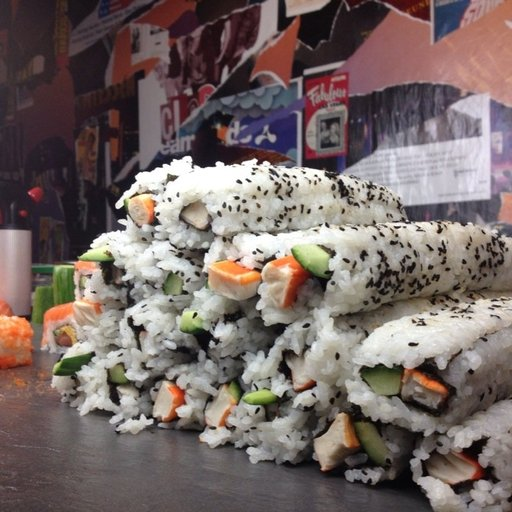

In [6]:
# Visualize the data
import random
from PIL import Image

# Set seed 
# random.seed(42)

# Get image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

# Image class from path
image_class = random_image_path.parent.stem
print(f"Image class: {image_class}")

# Open image
img = Image.open(random_image_path)
print(f"Image size: {img.size}")
img

In [7]:
# Visualize image with matplotlib
def show_image(image_path):
    # Open image
    img = Image.open(image_path)
    # Get image class
    image_class = image_path.parent.stem
    # Plot image
    plt.imshow(img)
    plt.title(image_class)
    plt.axis("off")

In [8]:
# Convert image to tensor
import numpy as np
def image_to_tensor(image_path):
    # Open image
    img = Image.open(image_path)
    # Convert to tensor
    img = torch.from_numpy(np.array(img))
    # Add color channel (since PyTorch expects a color channel)
    img = img.permute(2, 0, 1)
    # Normalize
    img = img.float() / 255.
    return img

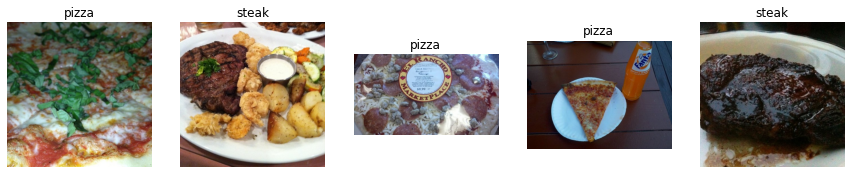

In [9]:
# Visualize 5 random images with matplotlib
def show_5_random_images(image_paths):
    # Get random image paths
    random_image_path_list = random.sample(image_paths, 5)
    # Plot images
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(random_image_path_list):
        plt.subplot(1, 5, i+1)
        show_image(image_path)
    plt.show()
    
show_5_random_images(image_paths=image_path_list)

Preprocess the dataset

In [10]:
from torchvision.transforms import ToTensor, Normalize, Compose, Resize, RandomHorizontalFlip, RandomRotation, RandomResizedCrop, RandomCrop
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset

In [11]:
# convert image to tensor
train_dataset = image_to_tensor(random_image_path)

In [12]:
# Load cifar10 dataset
from utils import load_cifar10_data, plot_datasets, plot_transformed_images

In [13]:
BATCH_SIZE = 128
WORKERS = 4
INPUT_SIZE = 64
OUTPUT_SIZE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Create data loaders
image_transforms = Compose(
    [
        Resize((INPUT_SIZE, INPUT_SIZE)),
        RandomRotation(degrees=15),
        RandomHorizontalFlip(p=0.5),
        ToTensor(),
        # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

test_transforms = Compose(
    [
        Resize((INPUT_SIZE, INPUT_SIZE)),
        RandomHorizontalFlip(p=0.5),
        ToTensor(),
        # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    
train = ImageFolder(train_path, transform=image_transforms)
food_train_dataloader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)

test = ImageFolder(test_path, transform=image_transforms)
food_test_dataloader = DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=True)

# Print sample sizes
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

print(f"Train batches: {food_train_dataloader.dataset[0][0].shape}")
print(f"Test batches: {food_test_dataloader.dataset[0][0].shape}")

Train size: 225
Test size: 75
Train batches: torch.Size([3, 64, 64])
Test batches: torch.Size([3, 64, 64])


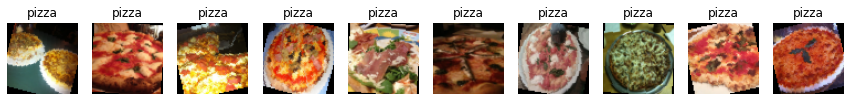

In [15]:
FOOD_CLASSES = train.classes

plot_datasets(food_train_dataloader.dataset, FOOD_CLASSES)

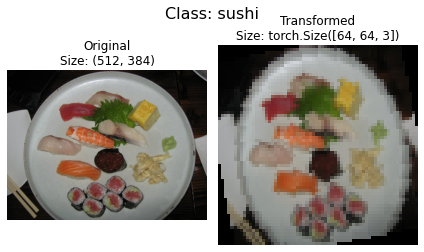

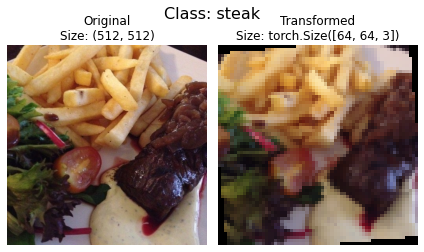

In [16]:
# Visualize transformed images
plot_transformed_images(image_paths=image_path_list, 
                        transforms=image_transforms, 
                        num_images=2)

Training

In [17]:
from networks import LeNet

In [18]:
from utils import get_input_dim
INPUT_SHAPE = get_input_dim(food_train_dataloader)

In [19]:
from trainer import fit_model

100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Epoch  1 -> Train loss: 2.7940 - Val loss: 1.1051 | Train acc: 0.29 - Val acc: 0.33


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Epoch  2 -> Train loss: 1.1490 - Val loss: 1.0895 | Train acc: 0.36 - Val acc: 0.33


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch  3 -> Train loss: 1.1051 - Val loss: 1.0926 | Train acc: 0.35 - Val acc: 0.33


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch  4 -> Train loss: 1.1003 - Val loss: 1.0946 | Train acc: 0.34 - Val acc: 0.33


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


Epoch  5 -> Train loss: 1.0999 - Val loss: 1.0958 | Train acc: 0.34 - Val acc: 0.33


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch  6 -> Train loss: 1.0996 - Val loss: 1.0952 | Train acc: 0.33 - Val acc: 0.33


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch  7 -> Train loss: 1.1006 - Val loss: 1.0953 | Train acc: 0.34 - Val acc: 0.33


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch  8 -> Train loss: 1.1007 - Val loss: 1.0962 | Train acc: 0.31 - Val acc: 0.32


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Epoch  9 -> Train loss: 1.0994 - Val loss: 1.0969 | Train acc: 0.34 - Val acc: 0.33


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch 10 -> Train loss: 1.0950 - Val loss: 1.0982 | Train acc: 0.37 - Val acc: 0.32


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch 11 -> Train loss: 1.0950 - Val loss: 1.0956 | Train acc: 0.38 - Val acc: 0.45


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


Epoch 12 -> Train loss: 1.0872 - Val loss: 1.0852 | Train acc: 0.44 - Val acc: 0.40


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch 13 -> Train loss: 1.0543 - Val loss: 1.1020 | Train acc: 0.44 - Val acc: 0.41


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Epoch 14 -> Train loss: 1.0650 - Val loss: 1.1692 | Train acc: 0.44 - Val acc: 0.43


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch 15 -> Train loss: 1.0590 - Val loss: 1.1238 | Train acc: 0.45 - Val acc: 0.33


100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


Epoch 16 -> Train loss: 1.0570 - Val loss: 1.0888 | Train acc: 0.46 - Val acc: 0.36


100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


Epoch 17 -> Train loss: 1.0732 - Val loss: 1.0625 | Train acc: 0.45 - Val acc: 0.36


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Epoch 18 -> Train loss: 1.0061 - Val loss: 1.0720 | Train acc: 0.54 - Val acc: 0.37


100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Epoch 19 -> Train loss: 1.0097 - Val loss: 1.0359 | Train acc: 0.53 - Val acc: 0.43


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch 20 -> Train loss: 0.9785 - Val loss: 0.9858 | Train acc: 0.56 - Val acc: 0.52


100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


Epoch 21 -> Train loss: 0.9655 - Val loss: 1.0111 | Train acc: 0.51 - Val acc: 0.44


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch 22 -> Train loss: 0.9620 - Val loss: 1.0820 | Train acc: 0.52 - Val acc: 0.45


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch 23 -> Train loss: 0.9179 - Val loss: 0.9843 | Train acc: 0.58 - Val acc: 0.44


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch 24 -> Train loss: 0.8983 - Val loss: 0.9530 | Train acc: 0.57 - Val acc: 0.53


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Epoch 25 -> Train loss: 0.9438 - Val loss: 1.0069 | Train acc: 0.55 - Val acc: 0.48


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


Epoch 26 -> Train loss: 0.9142 - Val loss: 0.9733 | Train acc: 0.54 - Val acc: 0.53


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


Epoch 27 -> Train loss: 0.8973 - Val loss: 0.9809 | Train acc: 0.60 - Val acc: 0.44


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch 28 -> Train loss: 0.8814 - Val loss: 0.9816 | Train acc: 0.60 - Val acc: 0.48


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch 29 -> Train loss: 0.8584 - Val loss: 0.9424 | Train acc: 0.62 - Val acc: 0.55


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch 30 -> Train loss: 0.8466 - Val loss: 0.9389 | Train acc: 0.62 - Val acc: 0.49


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch 31 -> Train loss: 0.8722 - Val loss: 1.1002 | Train acc: 0.61 - Val acc: 0.44


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch 32 -> Train loss: 0.8421 - Val loss: 0.9433 | Train acc: 0.64 - Val acc: 0.59


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


Epoch 33 -> Train loss: 0.8901 - Val loss: 0.9538 | Train acc: 0.60 - Val acc: 0.59


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Epoch 34 -> Train loss: 0.8446 - Val loss: 1.0328 | Train acc: 0.61 - Val acc: 0.45


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch 35 -> Train loss: 0.8905 - Val loss: 0.9275 | Train acc: 0.61 - Val acc: 0.59


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch 36 -> Train loss: 0.8547 - Val loss: 0.9123 | Train acc: 0.61 - Val acc: 0.57


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch 37 -> Train loss: 0.8210 - Val loss: 0.9609 | Train acc: 0.62 - Val acc: 0.52


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch 38 -> Train loss: 0.8447 - Val loss: 0.9054 | Train acc: 0.62 - Val acc: 0.60


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Epoch 39 -> Train loss: 0.8628 - Val loss: 0.8995 | Train acc: 0.62 - Val acc: 0.63


100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


Epoch 40 -> Train loss: 0.8078 - Val loss: 0.9466 | Train acc: 0.62 - Val acc: 0.61


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch 41 -> Train loss: 0.8015 - Val loss: 0.8705 | Train acc: 0.63 - Val acc: 0.59


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch 42 -> Train loss: 0.8016 - Val loss: 0.8802 | Train acc: 0.63 - Val acc: 0.60


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


Epoch 43 -> Train loss: 0.7512 - Val loss: 0.9005 | Train acc: 0.66 - Val acc: 0.59


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch 44 -> Train loss: 0.7761 - Val loss: 0.9086 | Train acc: 0.65 - Val acc: 0.60


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch 45 -> Train loss: 0.7249 - Val loss: 0.8589 | Train acc: 0.69 - Val acc: 0.61


100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


Epoch 46 -> Train loss: 0.7551 - Val loss: 0.8640 | Train acc: 0.67 - Val acc: 0.57


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch 47 -> Train loss: 0.7588 - Val loss: 0.8689 | Train acc: 0.66 - Val acc: 0.59


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Epoch 48 -> Train loss: 0.7476 - Val loss: 0.8684 | Train acc: 0.69 - Val acc: 0.64


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch 49 -> Train loss: 0.7669 - Val loss: 0.9160 | Train acc: 0.70 - Val acc: 0.63


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch 50 -> Train loss: 0.7514 - Val loss: 0.8726 | Train acc: 0.68 - Val acc: 0.61

Train time on cuda: 31.101 seconds


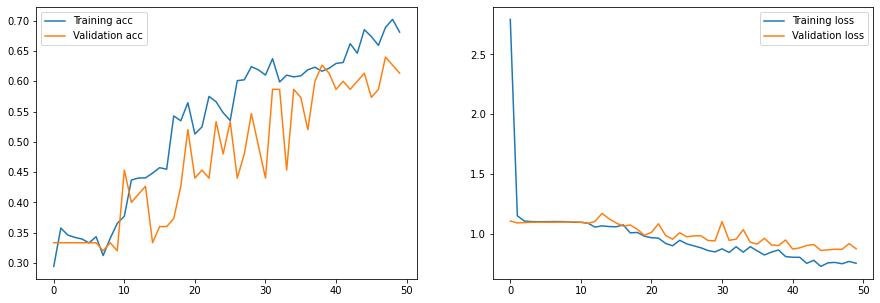

In [20]:
CRITERION = nn.CrossEntropyLoss()

model = LeNet(INPUT_SHAPE, OUTPUT_SIZE, BATCH_SIZE).to(DEVICE)
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.01)

history = fit_model(model, loss_fn=CRITERION, optimizer=OPTIMIZER, 
                   train_loader=food_train_dataloader,   
                   test_loader=food_test_dataloader,
                   device=DEVICE,
                   config={
                       "epochs": 50,
                   })